In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from glob import glob 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import to_categorical 
from keras.optimizers import Adam, SGD, RMSprop 
from keras.callbacks import EarlyStopping

import tensorflow as tf

Using TensorFlow backend.


In [3]:
path_train = "./dataset/train"
path_val = "./dataset/val"
path_test = "./dataset/test"

Text(0.5, 1.0, 'Pneumonia')

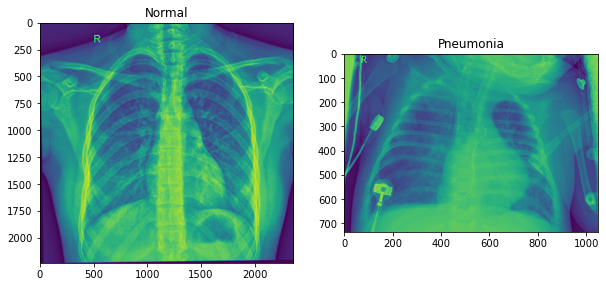

In [4]:
p_img = glob(path_train+"/PNEUMONIA/*.jpeg")
p_img = np.asarray(plt.imread(p_img[0]))

img = glob(path_train+"/NORMAL/*.jpeg") #Getting all images in this folder
img = np.asarray(plt.imread(img[0]))

f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(img)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(p_img)
a2.set_title('Pneumonia')


In [5]:
#Data preprocessing and analysis
classes = ["NORMAL", "PNEUMONIA"]
train_data = glob(path_train+"/NORMAL/*.jpeg")
train_data += glob(path_train+"/PNEUMONIA/*.jpeg")
data_gen = ImageDataGenerator()

In [6]:
train_batches = data_gen.flow_from_directory(path_train, target_size = (226, 226), classes = classes, class_mode = "categorical")
val_batches = data_gen.flow_from_directory(path_val, target_size = (226, 226), classes = classes, class_mode = "categorical")
test_batches = data_gen.flow_from_directory(path_test, target_size = (226, 226), classes = classes, class_mode = "categorical")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
#Based off of VGG16 Model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=train_batches.image_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


2022-04-03 16:50:15.280981: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-03 16:50:15.281926: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [8]:
#Viewing the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 226, 226, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 228, 228, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 226, 226, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 113, 113, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 115, 115, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 113, 113, 128)    

In [9]:
optimizer = Adam(lr = 0.0001)
early_stopping_monitor = EarlyStopping(patience = 3, monitor = "val_acc", mode="max")
model.compile(loss="categorical_crossentropy", 
                metrics=["accuracy", 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')], 
                optimizer=optimizer)
history = model.fit_generator(epochs=5, callbacks=[early_stopping_monitor], 
                shuffle=True, validation_data=val_batches, generator=train_batches, 
                steps_per_epoch=500, validation_steps=10)
prediction = model.predict_generator(generator=train_batches, steps=100)

Epoch 1/5
  4/500 [..............................] - ETA: 25:07:24 - loss: 1.7447 - accuracy: 0.6562 - precision: 0.7122 - recall: 0.7122

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()